# NEU502a
## Problem Set #3: The Drift Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from scipy.stats import norm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

---
As mentioned in class, the drift-diffusion model has been a dominant model in understanding how decisions are made. The model predicts one makes a decision by integrating evidence over time. Part of the power of the driftdiffusion model is how simple it is. The dynamics are captured by:

$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$

where $C$ is your decision variable, $v$ is the evidence that one is accumulating (the "drift"), and $w$ is the amount of noise in the integration (the "diffusion"). The initial condition is typically set to $C_0 = 0$ and the integration occurs to some bound $\pm B$, which initiates the choice. To get a better intuition for how the model works, we will simulate decision processes using the drift-diffusion model. 

For all of the questions, please provide one write-up with figures integrated. In addition, please submit your code alongside the writeup.

---

### The Drift Diffusion Model

In [2]:
def ddm(v, w, b=1, x0=0, dt=0.05):
    '''Simulation of diffusion-to-bound model.
    
    Parameters
    ----------
    v : scalar
      drift rate
    w : scalar
      drift noise
    b : scalar
      boundary
    x0 : scalar
      initial evidence
    dt : scalar
      time step (in seconds)
      
    Returns
    -------
    c : int
      decision [lb = -1, ub = 1]
    z : scalar
      reaction time (in seconds)
    x : array
      evidence accumulated
    '''
    
    ## Initialize values.
    x = [x0]
    z = 0
    
    ## Drift-to-bound. 
    while np.abs(x[-1]) < b:
        x_prime = x[-1] + v * dt + w * np.random.normal(0,1)
        x.append( x_prime )
        z += dt
        
    ## Determine choice.
    if x[-1] > b: c = 1
    else: c = -1
        
    return c, z, np.array(x)

### Problem 1
Simulate a simple decision process using the drift-diffusion model. Parameters should be $C_0 = 0$, $B = 1$, $dt = 0.05$ ms, $v=2.5$, and $w=0.05$. Run at least 1000 simulations to get a good sense of how the model behaves.

**a.** Plot a few (~10) model runs for both ‘correct’ and ‘incorrect’ trials. Briefly explain why the model occasionally makes decision errors.

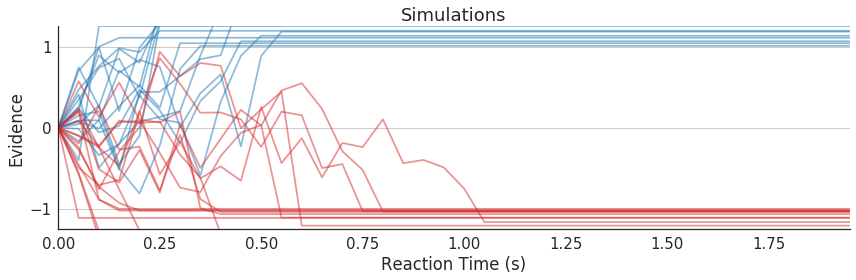

In [3]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## DDM parameters.
v = 2.5               # Drift rate
w = 0.5               # Drift noise
b = 1                 # Boundary
x0 = 0                # Initial evidence
dt = 0.05             # Timestep

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
C = np.zeros(n_samples)
Z = np.zeros(n_samples)
X = []

## Main loop.
for i in np.arange(n_samples):
    c, z, x = ddm(v=v, w=w, b=b, dt=dt, x0=x0)
    C[i], Z[i] = c, z
    X.append(x)
    
## Pad drift trajectories.
Xp = np.zeros((n_samples, max(len(x) for x in X)))
for i, x in enumerate(X):
    Xp[i,:len(x)] = x
    Xp[i,len(x):] = x[-1]
    
## Merge data.
data = DataFrame(np.vstack([C,Z]).T, columns=('Choice','RT'))
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
times = np.arange(Xp.shape[-1]) * 0.05
for c, color in zip([1,-1],['#1f77b4', '#d62728']):
    ix = np.random.choice(np.where(C==c)[0], 15, replace=False)
    ax.plot(times, Xp[ix].T, color=color, alpha=0.5)
    
ax.set(xlim=(0,times.max()), xlabel='Reaction Time (s)', ylim=(-b*1.25,b*1.25), 
       yticks=[-b,0,b], ylabel='Evidence', title='Simulations')
ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

sns.despine()
plt.tight_layout()

**Answer:** The model makes error when, by chance, enough evidence is accumulated towards the negative bound.

**b.** Plot the percentage of runs that ended in ‘correct’ and ‘incorrect’ choices.

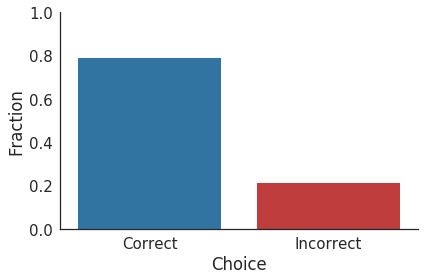

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot.
sns.countplot('Choice', data=data, palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n_samples), yticks=np.linspace(0,n_samples,6), 
       yticklabels=np.linspace(0,1,6).round(1), ylabel='Fraction')

sns.despine()
plt.tight_layout()

**c.** Plot the reaction time distribution for "correct" and "incorrect" trials separately. Describe the shape of the reaction time distribution (e.g. what is the mean? the median? is it symmetric or skewed?). Relate the shape of the reaction time distribution to human/animal behavioral responses.

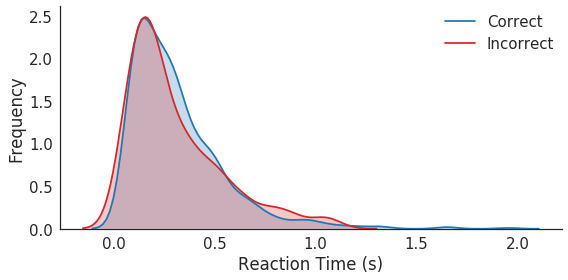

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
for label, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
    sns.kdeplot(data.loc[data.Choice==label,'RT'], shade=True, color=color, label=label)

ax.set(xlabel='Reaction Time (s)', ylabel='Frequency')
ax.legend(loc=1,borderpad=0)
    
sns.despine()
plt.tight_layout()

Reaction times are classically right-skewed as observed above. Why? It's easy to get slower but much harder to get faster.

### Problem 2
**a.** If sensory evidence is increased (2x) or decreased (0.5x), how does this impact the decision process in the drift-diffusion model? Describe how you modeled a change in the sensory evidence.

In [6]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## DDM parameters.
w = 0.5               # Drift noise
b = 1                 # Boundary
x0 = 0                # Initial evidence
dt = 0.05             # Timestep

## Changing evidence.
V = [5.0, 1.25]       # Drift rate

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data (strong evidence).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
Cs = np.zeros(n_samples)
Zs = np.zeros(n_samples)
Xs = []

## Main loop.
for i in np.arange(n_samples):
    c, z, x = ddm(v=V[0], w=w, b=b, dt=dt, x0=x0)
    Cs[i], Zs[i] = c, z
    Xs.append(x)
    
## Pad drift trajectories.
Xsp = np.zeros((n_samples, max(len(x) for x in X)))
for i, x in enumerate(X):
    Xsp[i,:len(x)] = x
    Xsp[i,len(x):] = x[-1]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data (weak evidence).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
Cw = np.zeros(n_samples)
Zw = np.zeros(n_samples)
Xw = []

## Main loop.
for i in np.arange(n_samples):
    c, z, x = ddm(v=V[1], w=w, b=b, dt=dt, x0=x0)
    Cw[i], Zw[i] = c, z
    Xw.append(x)
    
## Pad drift trajectories.
Xwp = np.zeros((n_samples, max(len(x) for x in X)))
for i, x in enumerate(X):
    Xwp[i,:len(x)] = x
    Xwp[i,len(x):] = x[-1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Merge data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for c, z, label in zip([C, Cs, Cw], [Z, Zs, Zw], ['Baseline','Strong','Weak']):

    ## Convert to DataFrame.
    df = DataFrame(np.vstack([c,z]).T, columns=('Choice','RT'))
    
    ## Add condition info. Append.
    df['Condition'] = label
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')

**b.** As for #1, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased)

##### Trace plots

##### Proportion of Choices

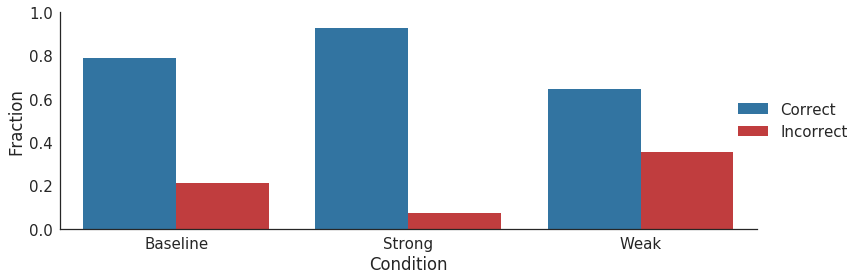

In [7]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.countplot('Condition', hue='Choice', data=data, 
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n_samples), yticks=np.linspace(0,n_samples,6), 
       yticklabels=np.linspace(0,1,6).round(1), ylabel='Fraction')
ax.legend(loc=7, bbox_to_anchor=(1.15,0.5))

sns.despine()
plt.tight_layout()

##### Reaction Times

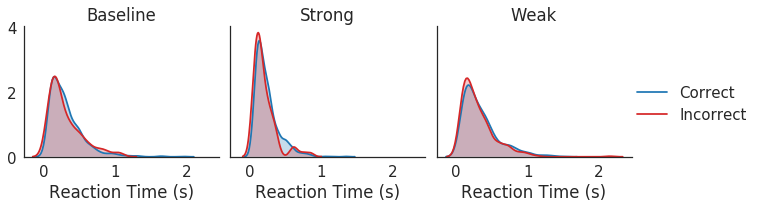

In [8]:
g = sns.FacetGrid(data, col='Condition', hue='Choice', size=3, aspect=1,
                  palette=['#1f77b4', '#d62728'])
g.map(sns.kdeplot, 'RT', shade=True)

g.set_xlabels('Reaction Time (s)')
g.set_titles(col_template='{col_name}')
g.add_legend(title='');

### Problem 3
Subjects appear to be able to trade accuracy for speed in most perceptual decision making tasks. The
drift-diffusion model can capture this tradeoff in a simple manner.

**a.** Describe how you modeled the accuracy/speed tradeoff. Why is this a biologically plausible way of capturing this effect?

In [9]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## DDM parameters.
v = 2.5
w = 0.5               # Drift noise
x0 = 0                # Initial evidence
dt = 0.05             # Timestep

## Changing boundary.
B = [0.5, 1.5]      # Boundary

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data (speed)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
Cs = np.zeros(n_samples)
Zs = np.zeros(n_samples)
Xs = []

## Main loop.
for i in np.arange(n_samples):
    c, z, x = ddm(v=v, w=w, b=B[0], dt=dt, x0=x0)
    Cs[i], Zs[i] = c, z
    Xs.append(x)
    
## Pad drift trajectories.
Xsp = np.zeros((n_samples, max(len(x) for x in X)))
for i, x in enumerate(X):
    Xsp[i,:len(x)] = x
    Xsp[i,len(x):] = x[-1]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data (accuracy).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
Ca = np.zeros(n_samples)
Za = np.zeros(n_samples)
Xa = []

## Main loop.
for i in np.arange(n_samples):
    c, z, x = ddm(v=v, w=w, b=B[1], dt=dt, x0=x0)
    Ca[i], Za[i] = c, z
    Xa.append(x)
    
## Pad drift trajectories.
Xap = np.zeros((n_samples, max(len(x) for x in X)))
for i, x in enumerate(X):
    Xap[i,:len(x)] = x
    Xap[i,len(x):] = x[-1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Merge data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for c, z, label in zip([Cs, Ca], [Zs, Za], ['Speed', 'Accuracy']):

    ## Convert to DataFrame.
    df = DataFrame(np.vstack([c,z]).T, columns=('Choice','RT'))
    
    ## Add condition info. Append.
    df['Condition'] = label
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')

**b.** Again, as in #1, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for your baseline model, an "accurate" biased model, and a "speed" biased model.

##### Trace plots

##### Proportion of Choices

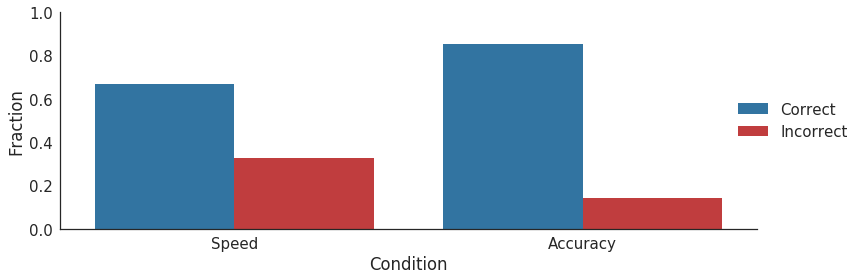

In [10]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.countplot('Condition', hue='Choice', data=data, 
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n_samples), yticks=np.linspace(0,n_samples,6), 
       yticklabels=np.linspace(0,1,6).round(1), ylabel='Fraction')
ax.legend(loc=7, bbox_to_anchor=(1.15,0.5))

sns.despine()
plt.tight_layout()

##### Reaction Times

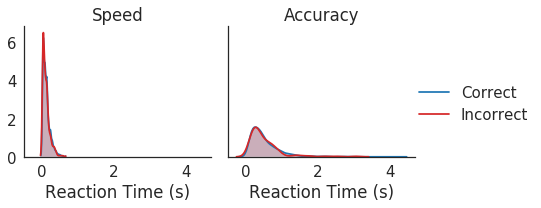

In [11]:
g = sns.FacetGrid(data, col='Condition', hue='Choice', size=3, aspect=1,
                  palette=['#1f77b4', '#d62728'])
g.map(sns.kdeplot, 'RT', shade=True)

g.set_xlabels('Reaction Time (s)')
g.set_titles(col_template='{col_name}')
g.add_legend(title='');

### Problem 4
Using the original "baseline" model, if you examine the reaction time distributions for correct and error
trials you'll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, let’s add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: 

$$ v = 2.5 + \mathcal{N}(0, 2.5) $$

Plot the reaction time distributions for both correct and incorrect trials. Describe the distributions as in #1. Does this better capture experimental observations?

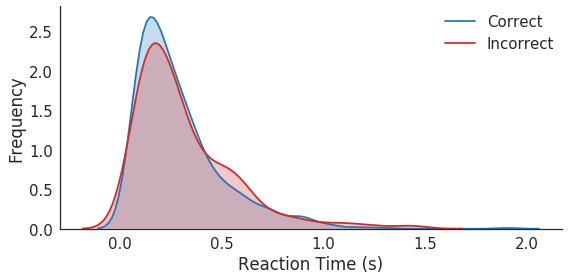

In [12]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define special drift rate.
v = lambda: 2.5 + norm(0,2.5).rvs()

## DDM parameters.
w = 0.5               # Drift noise
b = 1                 # Boundary
x0 = 0                # Initial evidence
dt = 0.05             # Timestep

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
n_samples = 1000
C = np.zeros(n_samples)
Z = np.zeros(n_samples)

## Main loop.
for i in np.arange(n_samples):
    c, z, _ = ddm(v=v(), w=w, b=b, dt=dt, x0=x0)
    C[i], Z[i] = c, z
    
## Merge data.
data = DataFrame(np.vstack([C,Z]).T, columns=('Choice','RT'))
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
for label, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
    sns.kdeplot(data.loc[data.Choice==label,'RT'], shade=True, color=color, label=label)

ax.set(xlabel='Reaction Time (s)', ylabel='Frequency')
ax.legend(loc=1,borderpad=0)
    
sns.despine()
plt.tight_layout()

Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

**Answer:** Because now, for some trials, evidence accumulation may be overtaken by noise. But positive drift will mean that it will take longer for drift to reach negative bound. 

Totally plausible given cholinergic circuitry. See Cohen & Aston-Jones (2005).